In [1]:
import os
import numpy as np
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score,recall_score,accuracy_score

In [2]:
#数据集
def getTrainAndTestSeqs(inPath, test_ratio=0.1):
    seqs = np.load(inPath)

    allItems = set()
    for seq in seqs:
        allItems|=set(seq[:-1])

    np.random.shuffle(seqs)
    split_number = int(len(seqs)*test_ratio)
    test = seqs[:split_number]
    train = seqs[split_number:]
    return train, test, allItems

train, test, allItems = getTrainAndTestSeqs('data_set/ml-latest-small/seqs.npy')
# print(train.shape) #(39949, 7)
print(len(allItems)) #6809

6809


In [3]:
#将除了第7列的内容进行转换
#构建item2id
item2id = {}
for i, item in enumerate(allItems):
    item2id[item] = i

#构建id2item
id2item = {v:k for k, v in item2id.items()}

#将id转为item
def id2itemFun(seq):
    return [id2item[id] for id in seq]

#将item转换为id
def item2idFun(seq):
    return [item2id[item] for item in seq]

In [4]:
#数据集
#训练集
train_x = train[:,0:6]
train_x = np.int64(np.array([item2idFun(seq) for seq in train_x]))

train_y = np.float32(train[:,6])

print(train_x[0])
print(train_y[0])

[1675 2448 3747  623 3942 5964]
1.0


In [5]:
#测试集
test_x = test[:,0:6]
test_x = np.int64(np.array([item2idFun(seq) for seq in test_x]))

test_y = np.float32(test[:,6])

print(test_x[0])
print(test_y[0])

[ 834 6678 5974 4717 4161  768]
1.0


In [6]:
#设置超参数
batch_size = 128

#使用dataset和dataloader包装数据集
train_dataset = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
test_dataset = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

In [7]:
#模型，使用rnn，一个embedding层，一个rnn层，一个全连接层，一个relu层

class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)
        self.relu = nn.Sigmoid()

    def forward(self, x, y6):
        x = self.embedding(x)
        out, hidden = self.rnn(x)
        out = self.linear(out)
        out = out[:,-1,:]

        #hidden和y6点乘，再非线性激活
        y6 = self.embedding(y6)
        hn = torch.sum(torch.mul(hidden, y6), dim=1)
        hn = self.relu(hn)
        return out, hn

#实例化模型
model = Model(len(allItems), 128, len(allItems))

#定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
BCE_loss = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epoch:1, loss:5.3663, c_loss:8.3403, b_loss:2.3922
epoch:2, loss:4.4886, c_loss:7.6078, b_loss:1.3695
epoch:3, loss:4.0885, c_loss:7.2990, b_loss:0.8779
epoch:4, loss:3.7835, c_loss:6.9863, b_loss:0.5806
epoch:5, loss:3.5035, c_loss:6.6392, b_loss:0.3678
epoch:6, loss:3.2428, c_loss:6.2621, b_loss:0.2235
epoch:7, loss:3.0020, c_loss:5.8669, b_loss:0.1371
epoch:8, loss:2.7818, c_loss:5.4684, b_loss:0.0953
epoch:9, loss:2.5818, c_loss:5.0874, b_loss:0.0762
epoch:10, loss:2.4023, c_loss:4.7380, b_loss:0.0666


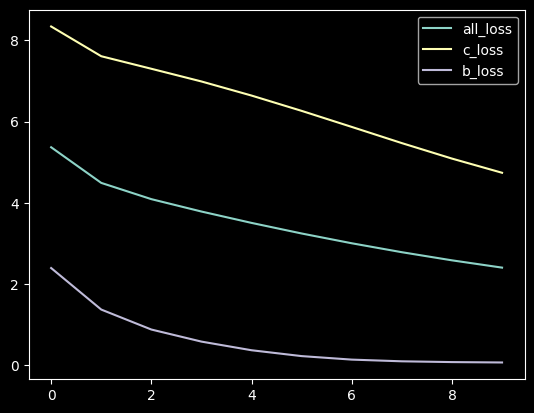

In [8]:
#训练模型
epochs = 10
all_loss = []
c_loss = []
b_loss = []
for epoch in range(epochs):
    mall_loss = 0
    mc_loss = 0
    mb_loss = 0
    for i, (x, y) in enumerate(train_loader):
        y6 = x[:,-1]
        x = x[:,:-1]

        #前向传播
        out, hn = model(x, y6)

        #计算损失
        loss1 = criterion(out, y6)
        mc_loss += loss1.item()

        loss2 = BCE_loss(hn, y.view(1,-1).float())
        mb_loss += loss2.item()
        loss = loss1*0.5 + loss2*0.5
        mall_loss += loss.item()

        #反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    all_loss.append(mall_loss/(i+1))
    c_loss.append(mc_loss/(i+1))
    b_loss.append(mb_loss/(i+1))
    print('epoch:{}, loss:{:.4f}, c_loss:{:.4f}, b_loss:{:.4f}'.format(epoch+1, all_loss[-1], c_loss[-1], b_loss[-1]))

#绘制损失函数图像
plt.plot(all_loss, label='all_loss')
plt.plot(c_loss, label='c_loss')
plt.plot(b_loss, label='b_loss')
plt.legend()
plt.show()        

In [9]:
def doEva(y_true, y_pred):
    #评估模型
    p = precision_score(y_true, y_pred)
    r = recall_score(y_true, y_pred)
    acc = accuracy_score(y_true,y_pred)
    return p,r,acc

In [10]:
model.eval()
with torch.no_grad():
    totalrec = 0
    totalpre = 0
    totalacc = 0
    for x, y in tqdm(test_loader):
        y6 = x[:,-1]
        x = x[:,:-1]


        #前向传播
        output, hn = model(x, y6)
        #将hn的值转为0或1
        hn = hn.view(-1)
        hn[hn >= 0.5] = 1.
        hn[hn < 0.5] = 0.
        
        p, r, acc = doEva(y, hn.view(-1))
        totalrec+=r
        totalpre+=p
        totalacc+=acc

n = len(test_loader)
print(f"recall is {totalrec / n}, Pre is {totalpre / n}, ACC is {totalacc / n}")

100%|██████████| 34/34 [00:01<00:00, 25.48it/s]

recall is 0.5486501103640262, Pre is 0.6408763420953203, ACC is 0.51953125
